# Basics of wiring diagrams


Using Catlab, you can create, manipulate, serialize, and visualize *wiring
diagrams*, also known as [string
diagrams](https://ncatlab.org/nlab/show/string+diagram). The flexible data
structure for wiring diagrams allows arbitrary data to be attached to boxes,
ports, and wires, and supports recursively nested diagrams.

You can interact with wiring diagrams using two different progamming
interfaces:

1. **Categorical**: A high-level, functional interface expressed in terms of
   categorical concepts, such as composition (`compose`), monoidal products
   (`otimes`), duplication (`mcopy`), and deletion (`delete`).

2. **Imperative**: A lower-level, mutating interface to directly manipulate
   boxes, ports, and wires, via operations like adding boxes (`add_box`) and
   wires (`add_wire`).

In this notebook, we introduce both interfaces. We do not explicitly cover the
visualization API, although for illustrative purposes we will draw wiring
diagrams using Graphviz. Thus, you should install
[Graphviz](https://www.graphviz.org/) if you wish to run this notebook.

In [1]:
using Catlab.WiringDiagrams

using Catlab.Graphics
import Catlab.Graphics: Graphviz

show_diagram(d::WiringDiagram) = to_graphviz(d,
  orientation=LeftToRight,
  labels=true, label_attr=:xlabel,
  node_attrs=Graphviz.Attributes(
    :fontname => "Courier",
  ),
  edge_attrs=Graphviz.Attributes(
    :fontname => "Courier",
  )
)

show_diagram (generic function with 1 method)

## Data structures

The basic building blocks of a wiring diagram are boxes, ports, and wires. The
top-level data structure is `WiringDiagram`, defined in the module
`Catlab.WiringDiagrams`. A wiring diagram consists of boxes (usually of type
`Box`) connected by wires (of type `Wire`). Each box has a sequence of input
ports and a sequence of output ports, as does the wiring diagram itself. The
wires have sources and targets, both of which consist of a box and a port on
that box.

The boxes in a wiring diagram are indexed by integer IDs. Boxes can be
retrieved by ID, and wires refer to boxes using their IDs. Two special IDs,
obtained by `input_id` and `output_id` methods, refer to the inputs and
outputs of the diagram itself. In this way, wires can connect the (inner)
boxes of a diagram to the diagram's "outer box".

The `WiringDiagram` data structure is an elaborate wrapper around a directed
graph from [LightGraphs.jl](https://github.com/JuliaGraphs/LightGraphs.jl).
The underlying `DiGraph` object can be accessed using the `graph` method. The
vertices of this graph are exactly the box IDs. The graph should never be
mutated directly, on pain of creating inconsistent state, but it does allow
convenient access to the large array of [graph
algorithms](https://juliagraphs.github.io/LightGraphs.jl/latest/) supported by
LightGraphs.

All this is somewhat abstract but should become clearer as we see concrete
examples.

## Categorical interface

In this example, the wiring diagrams will carry symbolic expressions (of type
`Catlab.ObExpr` and `Catlab.HomExpr`).

In [2]:
using Catlab.Theories

A, B, C, D = Ob(FreeBiproductCategory, :A, :B, :C, :D)
f = Hom(:f, A, B)
g = Hom(:g, B, C)
h = Hom(:h, C, D)

f

f

### Generators

Convert each of the morphism generators into a diagram with a single box.

In [3]:
f, g, h = to_wiring_diagram(f), to_wiring_diagram(g), to_wiring_diagram(h)
f

WiringDiagram{BiproductCategory}([:A], [:B], 
[ 1 => {inputs},
  2 => {outputs},
  3 => Box(:f, [:A], [:B]) ],
[ Wire((1,1) => (3,1)),
  Wire((3,1) => (2,1)) ])

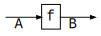

In [4]:
show_diagram(f)

### Composition

In [5]:
compose(f,g)

WiringDiagram{BiproductCategory}([:A], [:C], 
[ 1 => {inputs},
  2 => {outputs},
  3 => Box(:f, [:A], [:B]),
  4 => Box(:g, [:B], [:C]) ],
[ Wire((1,1) => (3,1)),
  Wire((3,1) => (4,1)),
  Wire((4,1) => (2,1)) ])

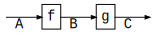

In [6]:
show_diagram(compose(f,g))

### Monoidal products

In [7]:
otimes(f,h)

WiringDiagram{BiproductCategory}([:A,:C], [:B,:D], 
[ 1 => {inputs},
  2 => {outputs},
  3 => Box(:f, [:A], [:B]),
  4 => Box(:h, [:C], [:D]) ],
[ Wire((1,1) => (3,1)),
  Wire((3,1) => (2,1)),
  Wire((1,2) => (4,1)),
  Wire((4,1) => (2,2)) ])

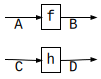

In [8]:
show_diagram(otimes(f,h))

### Copy and merge, delete and create

In [9]:
mcopy(codom(f),2)

WiringDiagram{BiproductCategory}([:B], [:B,:B], 
[ 1 => {inputs},
  2 => {outputs},
   ],
[ Wire((1,1) => (2,1)),
  Wire((1,1) => (2,2)) ])

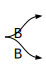

In [10]:
show_diagram(mcopy(codom(f),2))

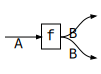

In [11]:
show_diagram(compose(f, mcopy(codom(f),2)))

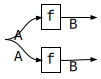

In [12]:
show_diagram(compose(mcopy(dom(f),2), otimes(f,f)))

## Imperative interface

We now show how to manipulate wiring diagrams using the low-level, imperative
interface. The diagrams will carry Julia symbols.

In [13]:
f = Box(:f, [:A], [:B])
g = Box(:g, [:B], [:C])
h = Box(:h, [:C], [:D])

f

Box(:f, [:A], [:B])

### Composition

For example, here is how to manually construct a composition of two boxes.

The `add_box!` method adds a box to a wiring diagrams and returns the ID
assigned to the box. How the boxes are indexed is an implementation detail
that you should not rely on; use the IDs that the system gives you.

In [14]:
d = WiringDiagram([:A], [:C])

fv = add_box!(d, f)
gv = add_box!(d, g)

add_wires!(d, [
  (input_id(d),1) => (fv,1),
  (fv,1) => (gv,1),
  (gv,1) => (output_id(d),1),
])

nboxes(d)

2

In [15]:
nwires(d)

3

In [16]:
d

WiringDiagram([:A], [:C], 
[ 1 => {inputs},
  2 => {outputs},
  3 => Box(:f, [:A], [:B]),
  4 => Box(:g, [:B], [:C]) ],
[ Wire((1,1) => (3,1)),
  Wire((3,1) => (4,1)),
  Wire((4,1) => (2,1)) ])

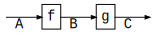

In [17]:
show_diagram(d)

### Products

Here is how to manually construct a product of two boxes.

In [18]:
d = WiringDiagram([:A,:C], [:B,:D])

fv = add_box!(d, f)
hv = add_box!(d, h)

add_wires!(d, [
  (input_id(d),1) => (fv,1),
  (input_id(d),2) => (hv,1),
  (fv,1) => (output_id(d),1),
  (hv,1) => (output_id(d),2),
])

d

WiringDiagram([:A,:C], [:B,:D], 
[ 1 => {inputs},
  2 => {outputs},
  3 => Box(:f, [:A], [:B]),
  4 => Box(:h, [:C], [:D]) ],
[ Wire((1,1) => (3,1)),
  Wire((1,2) => (4,1)),
  Wire((3,1) => (2,1)),
  Wire((4,1) => (2,2)) ])

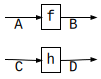

In [19]:
show_diagram(d)